# Emotion Classifier v2.0

This version of classifier is going to use the second version of the FER dataset namely FERplus which divides the emotions into 8 categories rather thanthe 7 in the earlier version. Similarly, as in the earlier model image augmentation is going to be used but only on the training data.

In [2]:
## Importing Required libraries
##importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import kaggle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Getting Data Ready

In [30]:
#Downloading Data
# Set the Kaggle dataset and file details
kaggle_dataset = 'subhaditya/fer2013plus'  # Example: 'zillow/zecon'
file_name = 'fer2013plus'  # Name of the file you want to download
data_folder = '../data'

# Create data directory if it does not exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(os.path.join(data_folder, file_name)):
    try:
        # Download the dataset file from Kaggle
        kaggle.api.dataset_download_files(dataset=kaggle_dataset, unzip =True, path=data_folder)
        print('Data downloaded and extracted.')

    except Exception as e:
        print(f"An error occurred: {e}")

2024-09-12 18:19:19,269 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /api/v1/datasets/download/subhaditya/fer2013plus?datasetVersionNumber=None


Dataset URL: https://www.kaggle.com/datasets/subhaditya/fer2013plus
Data downloaded and extracted.


Since we already have an idea of how each the images work and how they are set. We wont do much of explorations. Lets just have a look at few of the images from the dataset, since the data structure is a little different than the earlier version.

In [84]:
# Define the ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale and split

# Create generators
train_generator = train_datagen.flow_from_directory(
    '../data/fer2013plus/fer2013/train',  # Path to your dataset
    target_size=(48, 48),  # Resize images to the target size
    batch_size=32,  # Batch size
    color_mode = 'grayscale',
    shuffle = True,
    seed = 42,
    classes = ['anger','happiness','neutral','sadness'],
    class_mode='categorical')  # Set as training data

val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale and split

validation_generator = val_datagen.flow_from_directory(
    '../data/fer2013plus/fer2013/test',
    target_size=(48, 48),
    batch_size=32,
    classes = ['anger','happiness','neutral','sadness'],
    color_mode = 'grayscale',
    class_mode='categorical',
    shuffle = True,
    seed = 42)  # Set as validation data

Found 23816 images belonging to 4 classes.
Found 5924 images belonging to 4 classes.


In [85]:
from tensorflow.keras import regularizers

# Create the model
model = Sequential()

# Convolutional Layers with L2 Regularization and Batch Normalization
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers with Dropout
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Print the model summary
model.summary()

# Add Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can monitor 'val_accuracy' as well
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model with the best weights
)


c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,343,940 (8.94 MB)

 Trainable params: 2,343,236 (8.94 MB)

 Non-trainable params: 704 (2.75 KB)

In [65]:
# # Create the model
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(4, activation='softmax'))

# model.summary()

c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,342,532 (8.94 MB)

 Trainable params: 2,342,532 (8.94 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
)


Epoch 1/100


c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


745/745 ━━━━━━━━━━━━━━━━━━━━ 117s 152ms/step - accuracy: 0.3903 - loss: 11.2341 - val_accuracy: 0.5756 - val_loss: 2.3227
Epoch 2/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 108s 145ms/step - accuracy: 0.5652 - loss: 2.1752 - val_accuracy: 0.4193 - val_loss: 2.3047
Epoch 3/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 108s 145ms/step - accuracy: 0.6142 - loss: 1.7427 - val_accuracy: 0.6021 - val_loss: 1.6884
Epoch 4/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 108s 145ms/step - accuracy: 0.6289 - loss: 1.6736 - val_accuracy: 0.6082 - val_loss: 1.5876
Epoch 5/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.6431 - loss: 1.5335 - val_accuracy: 0.6388 - val_loss: 1.5306
Epoch 6/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 108s 145ms/step - accuracy: 0.6457 - loss: 1.5233 - val_accuracy: 0.6570 - val_loss: 1.5073
Epoch 7/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.6470 - loss: 1.4674 - val_accuracy: 0.7113 - val_loss: 1.3270
Epoch 8/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 111s 148ms/step - accuracy: 0.6558 - lo

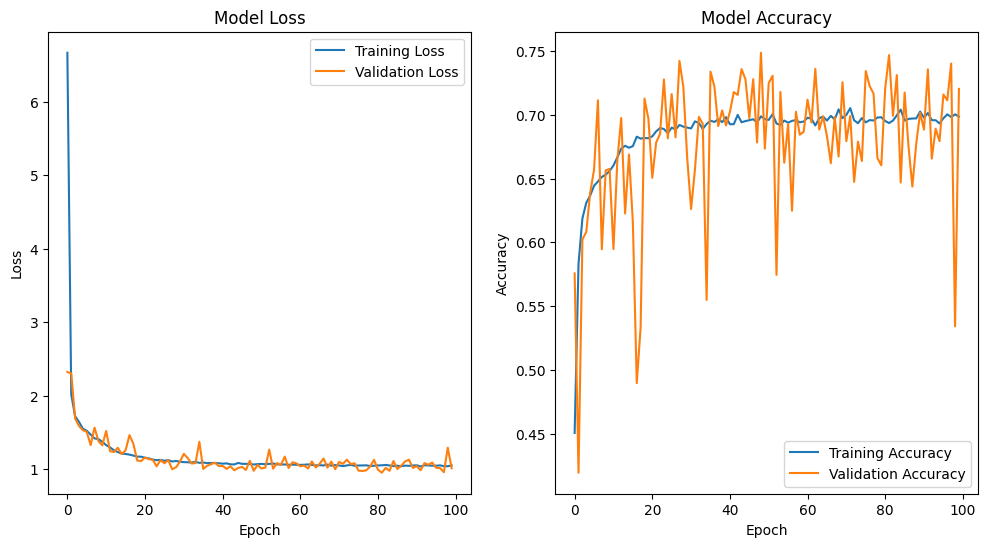

In [88]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
loss,accuracy = model.evaluate(validation_generator)
loss,accuracy

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7200 - loss: 1.0200


(1.0113554000854492, 0.7202903628349304)

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


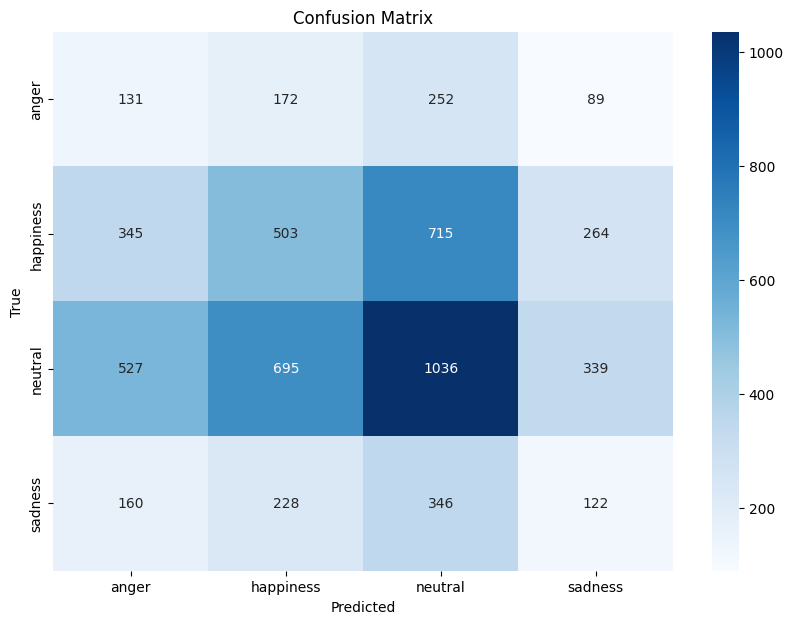

In [90]:
import seaborn as sns
true_classes = validation_generator.classes
predictions = model.predict(validation_generator)
pred_classes = np.argmax(predictions, axis=1)
class_labels = list(validation_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [92]:
class_labels = list(validation_generator.class_indices.keys())
print(classification_report(true_classes, pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

       anger       0.11      0.20      0.14       644
   happiness       0.31      0.28      0.29      1827
     neutral       0.44      0.40      0.42      2597
     sadness       0.15      0.14      0.15       856

    accuracy                           0.30      5924
   macro avg       0.25      0.26      0.25      5924
weighted avg       0.32      0.30      0.31      5924



In [94]:
import pickle
with open('../model/model_v2.pkl', 'wb') as file:
    pickle.dump(model, file)

  7/596 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step

c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


596/596 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step


array([3, 2, 2, ..., 1, 1, 2], dtype=int64)

array([[4.7570400e-02, 6.1583967e-04, 1.2240480e-01, 8.2940894e-01],
       [4.1528785e-04, 1.7779105e-04, 9.3700570e-01, 6.2401280e-02],
       [1.3750157e-03, 8.9874994e-03, 8.9613569e-01, 9.3501821e-02],
       ...,
       [2.6538846e-04, 9.5152950e-01, 4.4899821e-02, 3.3052783e-03],
       [1.3688264e-02, 9.0595132e-01, 2.5392152e-02, 5.4968327e-02],
       [1.5863735e-02, 7.4637271e-02, 6.9593519e-01, 2.1356384e-01]],
      dtype=float32)